# Mid Term Project
by:
Srinivasan Narayanan
and
Denny Meyer

<a id='content'></a>
### Table of content

<a href='#task'> 1. Introduction</a>
- motivation
- data set King County
- questions

<a href='#setup'>2. Setup libraries</a>

- pandas, numpy
- sklearn

    <a href='#helper_function'>2.1 Helper functions</a>
    - loading data table

    - plot data

    <a href='#data_functions'>2.2 Data functions</a>
    - interquartile range
    - remove series
    - create dummie table for categorizing
    - aggregate transformation

    <a href='#model_functions'>2.3 Model functions</a>
    - linear regression model with sklearn library
    - linear regression model with statsmodel api -> printing model results

<a href='#raw_data'>3. Review raw data</a>

- loading raw data

    <a href='#plot_raw'>3.1 Plot raw data</a>

    <a href='#heatmap'>3.2 Heatmap</a>



    <a href='#analyze_raw_data'>3.3 Discuss Raw Data</a>

[Version 1 model with nearly raw data](#version_1)

- using raw data

[Version 2 model limited input](#version_2)

- interquatile usage Bedrooms

[Version 3 model limited input](#version_3)

- interquartile bedrooms
- apply transformation 'boc-cox' 

[Version 4 categorizing zipcode](#version_4) 
- interquartile bedrooms
- categorizing zipcode, grade, bedrooms

<a href='#plot_regression'>plot regression graph</a>

<a href='#feature_importance'>feature importance</a>

<a href='#content'>back to content list</a>
<a id='setup'></a> 
### Setup

In [1]:
# import libraries

# dealing with data libs
import pandas as pd
import numpy as np


# dealing with date 
import datetime

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm # progressbar for looping


# machine learning libs
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, MinMaxScaler,RobustScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm





<a href='#content'>back to content list</a>
<a id='helper_function'></a> 
### Helper Functions

In [2]:
# ploting all numerical data from dataframe

def plot_numeric(data):
    for i in data._get_numeric_data():
        fig , ax = plt.subplots(1,2, figsize=(15,7))
        plt.title(i)
        sns.boxplot(x=data[i], ax=ax[0])
        sns.histplot(data[i], ax=ax[1])

        plt.show()

In [3]:
# ploting only on specific series

def plot_numeric_part(data: pd.DataFrame, name: str):
    plot_data = data[name]
    fig , ax = plt.subplots(1,2, figsize=(15,7))
    plt.title(name)
    sns.boxplot(x=plot_data, ax=ax[0])
    sns.histplot(plot_data, ax=ax[1])

    plt.show()

<a id='data_functions'></a>
<a href='#content'>back to content list</a>
### Functions for optional data handling:

#### option 1 Interquartile

In [4]:
# rip data in interquartile range

def reduce_to_interquartile(data: pd.DataFrame, name: list) -> pd.DataFrame:
    Q1 = data[name].quantile(0.25)
    Q3 = data[name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (data[name] >= Q1 - 1.5 * IQR) & (data[name] <= Q3 + 1.5 *IQR)
    data=data.loc[filter] 

    return data

#### option 2 remove

In [5]:
# remove column

def remove_column(data: pd.DataFrame, name: list) -> pd.DataFrame:
    data = data.drop(columns=name, inplace= True)

    return data

#### create dummy table for categorie

In [6]:
def create_dummies_for_categorie(data, name):
    data = pd.get_dummies(data, columns=[name], drop_first = True)
    return data

#### perform transformation operation on data

In [7]:
# transform operation

# input:
# - data: as panda datafram
# - name: column name where transformation should apply
# - operator: string value which operator should used -> pwr: PowerTransform, minmax: MinMaxTransform, robust: RobustTransform
# - lambda: if transformation can use a lambda value, otherwise 0 as default

# return:
# panda dataframe

pwr = PowerTransformer()
robust = RobustScaler()
minMax = MinMaxScaler()

def aggregate_transform(data: pd.DataFrame, name: str, operator: str = 'pwr', lamda_value: float = 0)-> pd.DataFrame:
    transformer = pwr

    if operator == 'pwr':
        transformer = pwr
    elif operator == 'minmax':
        transformer = minMax
    elif operator == 'robust':
        transformer = robust
    if lamda_value != 0:
        transformer.lambdas_ = lamda_value
    data[name] = transformer.fit_transform(data[name].to_numpy().reshape(-1,1))
    return data


#### apply scaler on given dataset

In [8]:
# takes train and test data as input, apply standart scaler fitted on traindata and return both datasets

def apply_standart_scaler(x_train_data: pd.DataFrame, x_test_data: pd.DataFrame):
    scaler_train = StandardScaler().fit(x_train_data)
    scaler_train.transform(x_train_data)
    scaler_train.transform(x_test_data)
    return x_train_data, x_test_data

<a id='model_functions'></a>
<a href='#content'>back to content list</a>
#### model functions

In [19]:
# create linear regression model using sklearn library
# this one is heavily used during the whole process

def create_linear_model(x_train: pd.DataFrame, y_train: pd.DataFrame) -> LinearRegression:
    model_l = LinearRegression()
    model_l.fit(x_train, y_train)

    return model_l

In [20]:
# create linear regression model using statsmodel api
# this one is mainly used for presenting r2 and score values for used input values
# as it´s summary function offers a pretty handy way for displaying the results

def create_linear_model_statsmodel_analyze(x_train: pd.DataFrame, y_train: pd.DataFrame):
    x_train_sm = sm.add_constant(x_train) # adding a constant
    model = sm.OLS(list(y_train), x_train_sm).fit()

    return model.summary() # just print the summary as table 


#### plot function 

In [45]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

def plot_train_vs_test(y_pred_train, y_pred_test, y_test, y_train):
    result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred_test})
    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    fig, ax = plt.subplots(2,3,figsize=(18,10))
    ax[0,0].plot(y_pred_test, y_test, 'o',color='red')
    ax[0,0].set_xlabel("y_test")
    ax[0,0].set_ylabel("y_pred")
    ax[0,0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[0,1].hist(y_test - y_pred_test, color='red')
    ax[0,1].set_xlabel("Test y-y_pred")
    ax[0,1].set_title("Test Set Residual histogram")

    ax[0,2].plot(y_pred_test,y_test - y_pred_test,"o", color='red')
    ax[0,2].set_xlabel("predited")
    ax[0,2].set_ylabel("residuals")
    ax[0,2].set_title("Residuals by Predicted")
    ax[0,2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')



    ax[1,0].plot(y_pred_train, y_train, 'o')
    ax[1,0].set_xlabel("y_train")
    ax[1,0].set_ylabel("y_pred_train")
    ax[1,0].set_title("Train set Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1,1].hist(y_train - y_pred_train)
    ax[1,1].set_xlabel("Train y-y_pred")
    ax[1,1].set_title("Train Residual histogram")

    ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
    ax[1,2].set_xlabel("predited")
    ax[1,2].set_ylabel("residuals")
    ax[1,2].set_title("Residuals by Predicted -- Train set")
    ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')
    

<a id='raw_data'></a>
<a href='#content'>back to content list</a>
### load raw data

In [22]:
# load data and create work_copy

raw_data = pd.read_excel('../data/Data_MidTerm_Project_Real_State_Regression.xls')


### Data review

In [23]:
raw_data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


<a id='plot_raw'></a>
<a href='#content'>back to content list</a>
### Plotting raw data

In [24]:
# analyze raw data
#plot_numeric(work_copy)
#sns.pairplot(work_copy,diag_kind="kde")

<a id='heatmap'></a>
<a href='#content'>back to content list</a>

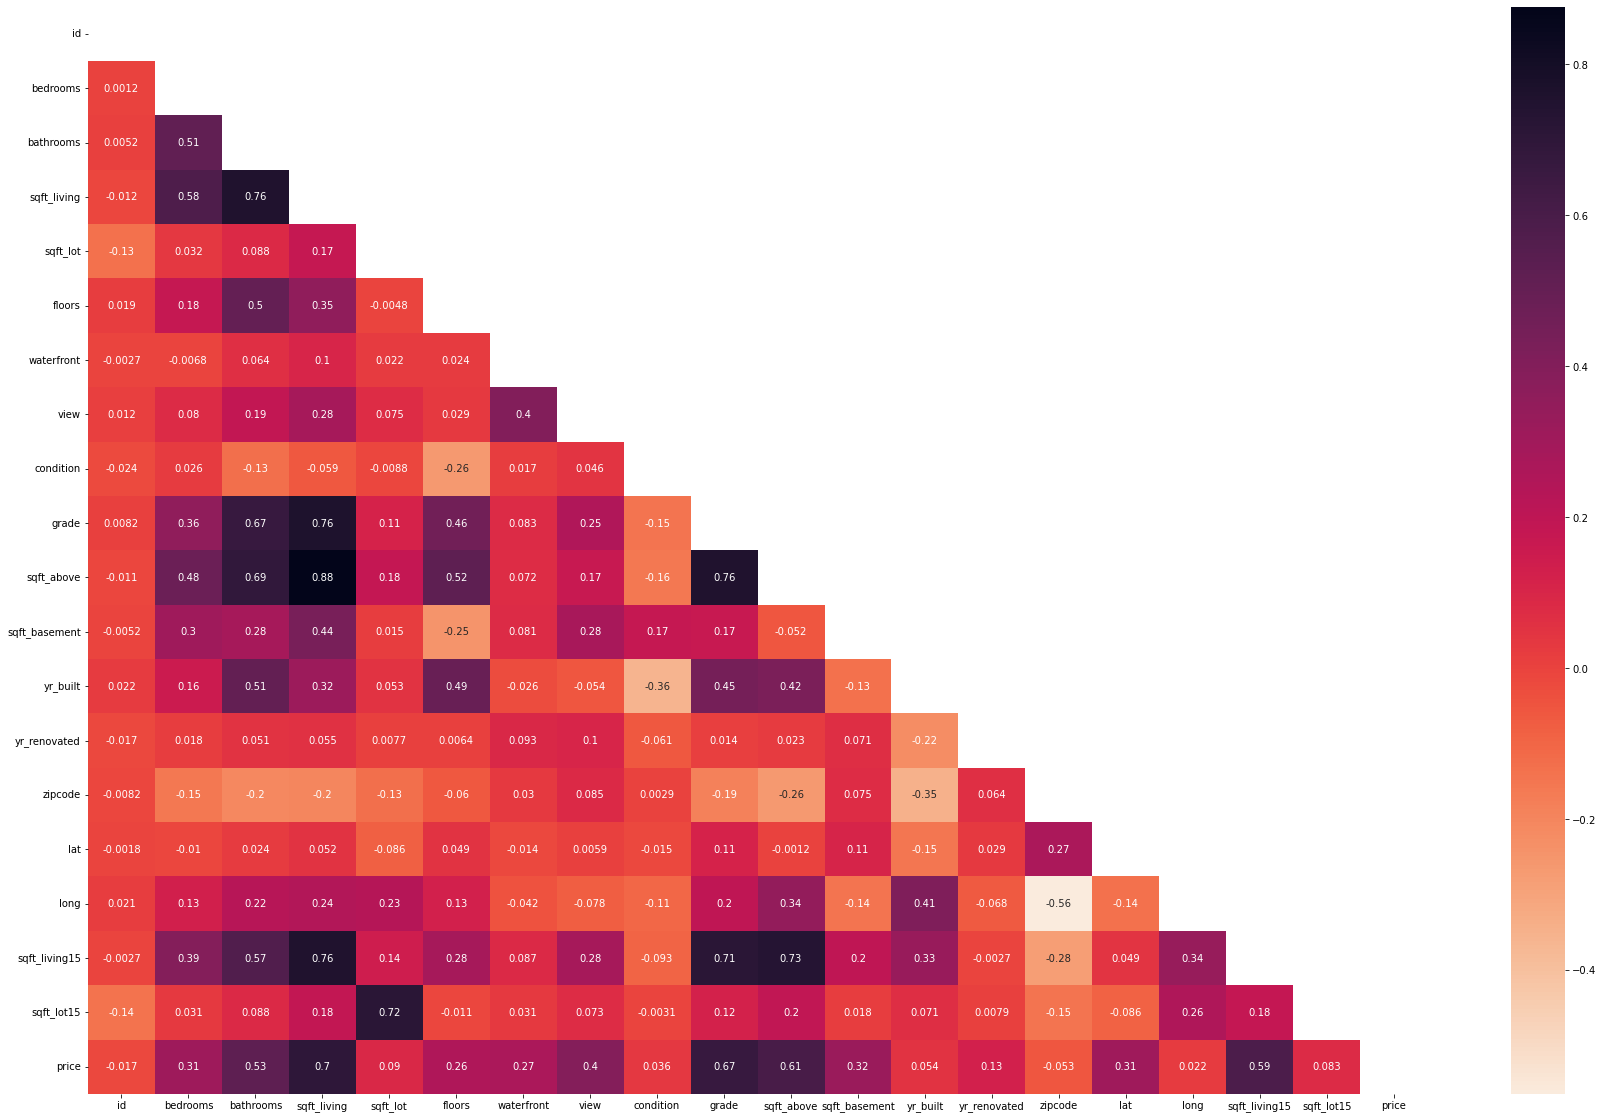

In [25]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(raw_data._get_numeric_data().corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(30, 20))
ax=sns.heatmap(raw_data._get_numeric_data().corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

<a id='analyze_raw_data'></a>
<a href='#content'>back to content list</a>
### **Discussion raw data:** 

> id -> will be removed as not mandatory
>
> bedrooms -> need adjustments as max 33 could be an outlayer, without -> normal distributed
>
> bathrooms -> max 8 needs to check, if its fits with connected sqft range ->
>
> sqft_living -> maybe recalculated in square meter to fit better in european perspective
>
> sqft_lot -> similar to sqft_living
>
> floors -> maybe changable to ordonal categorical
>
> waterfront -> set to categorical 
>
> view -> needs review why min to 75% is zero with an max of 4
>
> condition -> transform to ordonal categorical 0-5
>
> grade -> as descripted typical ordonal categorical 0-13
>
> sqft_above -> similar to sqft_living
>
> sqft_basement -> similar to sqft_living
> - as sqft_basement looks without zero numbers as normal distributed
> - ***ToDo:*** drop zero values from this column
> - create category 'has_basement'
> - fill all 'has_basement' where basement is included
>
> yr_build -> use as number or could be ordonal category when binning with steps e.g 5 years 1900-1905 ....
>
> zip code, lat and long -> skipt or could binning or clustered to regions 
>
> sqft_living15 and sqft_lot15 represents the average living and lot sqft of the closest 15 neiboorhouses





<a id='version_1'></a>
### Version 1
<a href='#content'>back to content list</a>


This example using nearly the whole data set to get a first impression.

Only ID and Date will dropped as ID holds no usefull information

The Date can not used without further transformation

In [56]:
# drop first not need data
work_copy_v1= raw_data.copy()

work_copy_v1.drop(columns=['id', 'date'], inplace=True)


In [57]:
# drop label or dependent value for ML
label_v1 = work_copy_v1['price']
work_copy_v1.drop(columns='price', inplace=True)


In [58]:
# split dataset in 80% training data and hold 20% for evaluating the results

x_train_v1, x_test_v1, y_train_v1, y_test_v1 = train_test_split(work_copy_v1, label_v1, test_size=0.2, random_state=42)

In [60]:
# apply standart scale on train and test data
# Note: the function behind will fit the scaler only with the training data, but apply the resulting scaler in both sets

x_train_v1, x_test_v1 = apply_standart_scaler(x_train_data=x_train_v1, x_test_data=x_test_v1)

In [61]:
# linear model with sklearn 

model_v1 = create_linear_model(x_train=x_train_v1, y_train=y_train_v1)

In [62]:
# just a handy plot to check internal values

create_linear_model_statsmodel_analyze(x_train_v1, y_train_v1)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2392.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:18:00   Log-Likelihood:            -2.3552e+05
No. Observations:               17277   AIC:                         4.711e+05
Df Residuals:                   17259   BIC:                         4.712e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.188e+06   3.28e+06      1.884      0.060   -2.49e+05    1.26e+07
bedrooms      -3.835e+04   2212.127    -17.335      0.000   -4.27e+04    -3.4e+04
bathrooms      4.213e+04   3681.555     11.442      0.000    3.49e+04    4.93e+04
sqft_living     110.6321      2.581     42.869      0.000     105.574     115.691
sqft_lot          0.1037      0.055      1.898      0.058      -0.003       0.211
floors         8383.0996   4031.878      2.079      0.038     480.210    1.63e+04
waterfront     5.789e+05   1.93e+04     29.926      0.000    5.41e+05    6.17e+05
view           5.172e+04   2399.625     21.552      0.000     4.7e+04    5.64e+04
condition      2.863e+04   2633.790     10.870      0.000    2.35e+04    3.38e+04
grade          9.871e+04   2419.834     40.794      0.000     9.4e+04    1.03e+05
sqft_above       69.0376      2.542     27.154      0.000      64.054      74.021
sqft_basement    41.5972      2.976     13.978      0.000      35.764      47.430
yr_built      -2683.4602     81.391    -32.970      0.000   -2842.994   -2523.926
yr_renovated     19.5500      4.106      4.761      0.000      11.502      27.598
zipcode        -562.6960     36.930    -15.237      0.000    -635.082    -490.310
lat              5.9e+05    1.2e+04     48.963      0.000    5.66e+05    6.14e+05
long          -2.088e+05   1.46e+04    -14.276      0.000   -2.37e+05    -1.8e+05
sqft_living15    24.6215      3.890      6.330      0.000      16.997      32.246
sqft_lot15       -0.4517      0.082     -5.515      0.000      -0.612      -0.291
==============================================================================
Omnibus:                    14778.856   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1466590.026
Skew:                           3.606   Prob(JB):                         0.00
Kurtosis:                      47.557   Cond. No.                     1.18e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.25e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [53]:
# create predictions

y_pred_train_v1 = model_v1.predict(x_train_v1)
y_pred_test_v1 = model_v1.predict(x_test_v1)

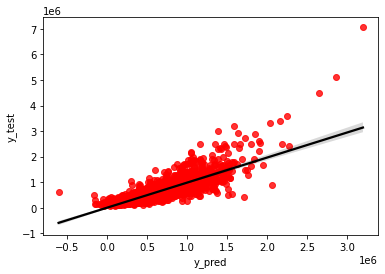

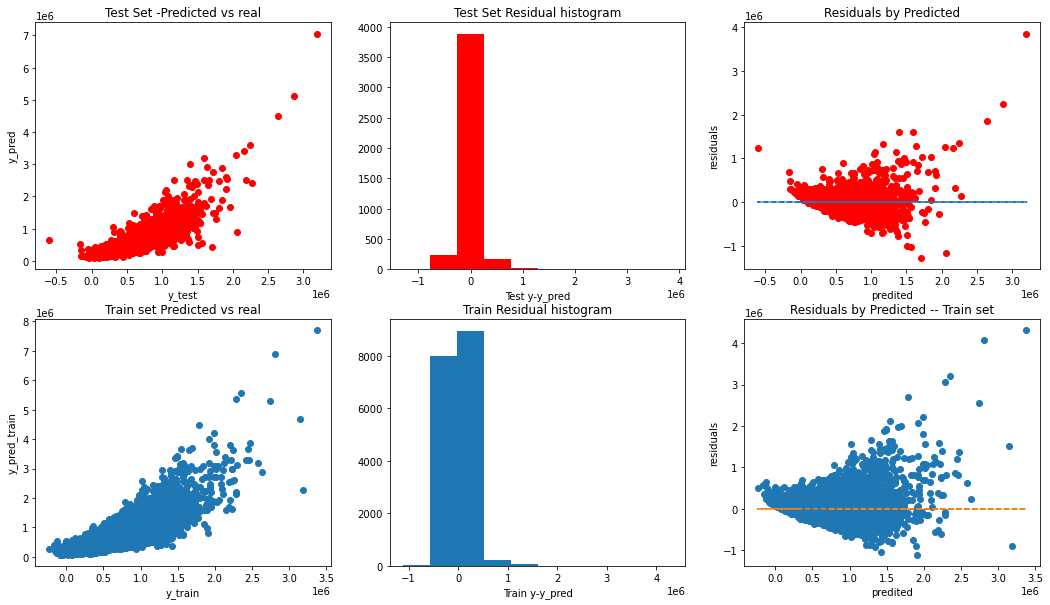

In [63]:
# compare train and test predictions

plot_train_vs_test(y_pred_test=y_pred_test_v1, y_pred_train=y_pred_train_v1, y_test=y_test_v1, y_train=y_train_v1)

In [65]:
features_importances = pd.DataFrame(data={
    'Attribute': x_train_v1.columns,
    'Importance': abs(model_v1.coef_)
})

features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
14,lat,589969.594598
5,waterfront,578940.273893
15,long,208788.216055
8,grade,98713.513694
6,view,51717.326838
1,bathrooms,42125.942503
0,bedrooms,38346.695094
7,condition,28629.833696
4,floors,8383.099561
11,yr_built,2683.460201


<AxesSubplot:xlabel='Attribute', ylabel='Importance'>

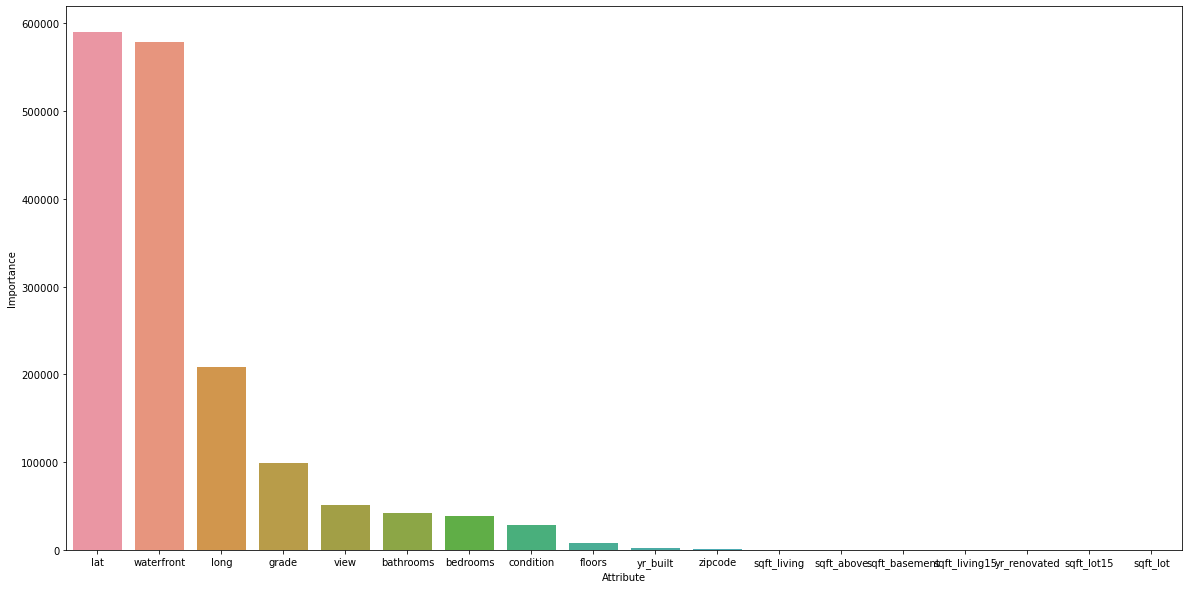

In [66]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=features_importances['Attribute'], y=features_importances['Importance'])

### Discussion

First run show


<a id='version_2'></a>
### Version 2

[back to content](#content)

In [274]:
# droping long and lat coordinates, as this location information is allready included in the zipcodes
work_copy.drop(columns=['long', 'lat'], inplace=True)

#work_copy.drop(columns=['long'], inplace=True)

In [275]:
# test for dropping all to fill in an input value and receive an return price
#work_copy.drop(columns=['waterfront', 'grade', 'bedrooms', 'bathrooms', 'yr_built', 'sqft_basement', 'lat','zipcode', 'condition'], inplace=True)

In [276]:
# interquartile sqft_living

work_copy =  work_copy[work_copy['bedrooms'] != 33]
work_copy = reduce_to_interquartile(data=work_copy, name='bedrooms')

In [277]:
#work_copy = reduce_to_interquartile(data=work_copy, name='price')
transpower = PowerTransformer(method='box-cox')
work_copy['price'] = transpower.fit_transform(work_copy['price'].to_numpy().reshape(-1,1))
work_copy['sqft_living'] = transpower.fit_transform(work_copy['sqft_living'].to_numpy().reshape(-1,1))
work_copy['sqft_living15'] = transpower.fit_transform(work_copy['sqft_living15'].to_numpy().reshape(-1,1))
work_copy['yr_built'] = transpower.fit_transform(work_copy['yr_built'].to_numpy().reshape(-1,1))

#work_copy['bathrooms'] = transpower.fit_transform(work_copy['bathrooms'].to_numpy().reshape(-1,1))

#trans_f = PowerTransformer()
#work_copy['yr_renovated'] = trans_f.fit_transform(work_copy['yr_renovated'].to_numpy().reshape(-1,1))

In [278]:
# basement has no real influence so i transform this to an binary has or has not field 0 or 1
work_copy['sqft_basement'].values[work_copy['sqft_basement'] != 0] = 1


In [279]:
work_copy['yr_renovated'].values[work_copy['yr_renovated'] != 0] = 1

In [280]:
work_copy = create_dummies_for_categorie(work_copy, 'zipcode')

In [281]:
work_copy = create_dummies_for_categorie(work_copy, 'grade')

In [282]:
work_copy = create_dummies_for_categorie(work_copy, 'floors')

In [283]:
work_copy = create_dummies_for_categorie(work_copy, 'bedrooms')

In [284]:
work_copy = create_dummies_for_categorie(work_copy, 'condition')

In [285]:
work_copy = create_dummies_for_categorie(work_copy, 'bathrooms')

In [286]:
#plot_numeric(work_copy)

#sns.pairplot(work_copy,diag_kind="kde")

In [287]:
work_copy.describe()

,sqft_living,waterfront,sqft_basement,yr_built,yr_renovated,sqft_living15,price,zipcode_98002,zipcode_98003,zipcode_98004,...,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75
count,2.106700e+04,21067.000000,21067.000000,2.106700e+04,21067.000000,2.106700e+04,2.106700e+04,21067.000000,21067.000000,21067.000000,...,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000
mean,-5.498257e-16,0.007310,0.390469,5.972659e-15,0.041202,2.433068e-15,-1.387290e-14,0.008924,0.013054,0.014762,...,0.003418,0.000854,0.000665,0.000427,0.000427,0.000142,0.000190,0.000095,0.000047,0.000047
std,1.000024e+00,0.085188,0.487867,1.000024e+00,0.198762,1.000024e+00,1.000024e+00,0.094046,0.113507,0.120603,...,0.058362,0.029219,0.025771,0.020665,0.020665,0.011933,0.013778,0.009743,0.006890,0.006890
min,-3.568414e+00,0.000000,0.000000,-2.010479e+00,0.000000,-5.682120e+00,-4.248885e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.885356e-01,0.000000,0.000000,-7.554753e-01,0.000000,-7.010326e-01,-6.739056e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.311971e-02,0.000000,0.000000,5.008419e-03,0.000000,-3.271712e-02,4.363233e-03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.925507e-01,0.000000,1.000000,8.843285e-01,0.000000,7.156469e-01,6.653952e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.994567e+00,1.000000,1.000000,1.734074e+00,1.000000,3.254690e+00,3.957004e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### First Approach with unfilterd data

In [288]:
label = work_copy['price']
work_copy.drop(columns='price', inplace=True)

In [289]:
x_train, x_test, y_train, y_test = train_test_split(work_copy, label, test_size= 0.20, random_state= 42)

In [290]:
x_train.describe()

,sqft_living,waterfront,sqft_basement,yr_built,yr_renovated,sqft_living15,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,...,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75
count,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,...,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000,16853.000000
mean,-0.000903,0.007714,0.390850,-0.000347,0.041654,-0.002983,0.008604,0.012639,0.014834,0.007358,...,0.003442,0.000653,0.000712,0.000415,0.000356,0.000059,0.000237,0.000119,0.000059,0.000059
std,0.998740,0.087491,0.487955,1.001000,0.199804,0.998995,0.092360,0.111713,0.120892,0.085464,...,0.058565,0.025540,0.026675,0.020377,0.018866,0.007703,0.015405,0.010893,0.007703,0.007703
min,-3.568414,0.000000,0.000000,-2.010479,0.000000,-5.682120,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.688536,0.000000,0.000000,-0.755475,0.000000,-0.701033,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.013120,0.000000,0.000000,0.005008,0.000000,-0.032717,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.702070,0.000000,1.000000,0.884328,0.000000,0.715647,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.994567,1.000000,1.000000,1.734074,1.000000,3.216518,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [291]:
scaler_train = StandardScaler().fit(x_train)
#scaler_train = RobustScaler().fit(x_train)
#scaler_train = MinMaxScaler().fit(x_train)

scaler_train.transform(x_train)
scaler_train.transform(x_test)


array([[ 0.26671878, -0.08816873, -0.80101971, ..., -0.01089437,
        -0.00770326, -0.00770326],
       [ 0.60680728, -0.08816873,  1.24840873, ..., -0.01089437,
        -0.00770326, -0.00770326],
       [ 0.07666231, -0.08816873, -0.80101971, ..., -0.01089437,
        -0.00770326, -0.00770326],
       ...,
       [ 0.25527183, -0.08816873, -0.80101971, ..., -0.01089437,
        -0.00770326, -0.00770326],
       [ 0.4952688 , -0.08816873, -0.80101971, ..., -0.01089437,
        -0.00770326, -0.00770326],
       [-0.52425033, -0.08816873, -0.80101971, ..., -0.01089437,
        -0.00770326, -0.00770326]])

In [430]:
#model_l = LinearRegression()
#model_l = Lasso()

#model_l.fit(x_train, y_train)

model_l = create_linear_model(x_train=x_train, y_train=y_train)

In [431]:
y_pred_train = model_l.predict(x_train)
y_pred_test = model_l.predict(x_test)


In [432]:
create_linear_model_statsmodel_analyze(x_train, y_train)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     890.2
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:00:32   Log-Likelihood:                -7008.3
No. Observations:               16853   AIC:                         1.426e+04
Df Residuals:                   16731   BIC:                         1.520e+04
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.2527      0.394     -5.714      0.000      -3.025      -1.480
sqft_living        0.3590      0.007     52.582      0.000       0.346       0.372
waterfront         1.0724      0.034     31.498      0.000       1.006       1.139
sqft_basement     -0.0816      0.008    -10.506      0.000      -0.097      -0.066
yr_built          -0.0226      0.006     -4.059      0.000      -0.034      -0.012
yr_renovated       0.1378      0.016      8.838      0.000       0.107       0.168
sqft_living15      0.1332      0.005     27.014      0.000       0.124       0.143
zipcode_98002     -0.0642      0.038     -1.698      0.090      -0.138       0.010
zipcode_98003      0.0329      0.034      0.981      0.327      -0.033       0.099
zipcode_98004      2.0085      0.033     61.568      0.000       1.945       2.072
zipcode_98005      1.3943      0.040     34.725      0.000       1.316       1.473
zipcode_98006      1.2426      0.030     42.015      0.000       1.185       1.301
zipcode_98007      1.2678      0.043     29.741      0.000       1.184       1.351
zipcode_98008      1.2978      0.033     38.855      0.000       1.232       1.363
zipcode_98010      0.5857      0.047     12.579      0.000       0.494       0.677
zipcode_98011      0.8764      0.037     23.422      0.000       0.803       0.950
zipcode_98014      0.7312      0.044     16.749      0.000       0.646       0.817
zipcode_98019      0.6599      0.038     17.365      0.000       0.585       0.734
zipcode_98022      0.2285      0.035      6.440      0.000       0.159       0.298
zipcode_98023     -0.0964      0.029     -3.341      0.001      -0.153      -0.040
zipcode_98024      1.0268      0.054     19.146      0.000       0.922       1.132
zipcode_98027      1.0294      0.030     33.858      0.000       0.970       1.089
zipcode_98028      0.8172      0.033     24.865      0.000       0.753       0.882
zipcode_98029      1.1526      0.032     35.595      0.000       1.089       1.216
zipcode_98030      0.0897      0.033      2.692      0.007       0.024       0.155
zipcode_98031      0.1224      0.033      3.660      0.000       0.057       0.188
zipcode_98032     -0.0719      0.044     -1.634      0.102      -0.158       0.014
zipcode_98033      1.4996      0.030     50.164      0.000       1.441       1.558
zipcode_98034      1.0941      0.028     38.439      0.000       1.038       1.150
zipcode_98038      0.3386      0.028     12.137      0.000       0.284       0.393
zipcode_98039      2.1604      0.064     33.652      0.000       2.035       2.286
zipcode_98040      1.6260      0.034     47.854      0.000       1.559       1.693
zipcode_98042      0.1373      0.028      4.860      0.000       0.082       0.193
zipcode_98045      0.7487      0.036     21.019      0.000       0.679       0.819
zipcode_9805

<a id='plot_regression'></a>
<a href='#content'>back to content list</a>
### Plot Regression Graph

In [433]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred_test})

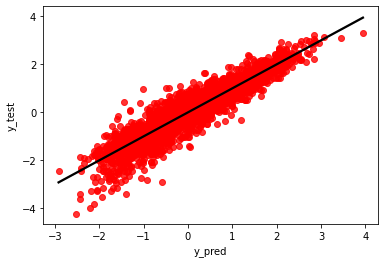

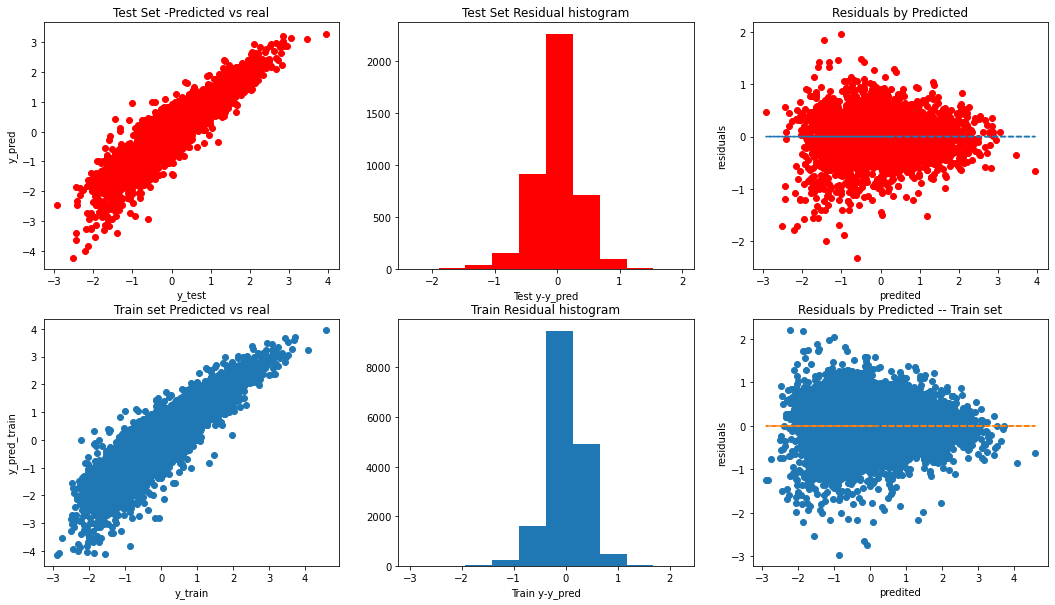

In [434]:

sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plot_train_vs_test(y_pred_test= y_pred_test, y_test=y_test, y_pred_train=y_pred_train)

<a id='feature_importance'></a>
<a href='#content'>back to content list</a>

In [297]:
features_importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(model_l.coef_)
})


# seperate features
zip_mean = features_importances[features_importances['Attribute'].str.startswith('zip') == True]
grade_mean = features_importances[features_importances['Attribute'].str.startswith('grade') == True]
floors_mean = features_importances[features_importances['Attribute'].str.startswith('floor') == True]
condition_mean = features_importances[features_importances['Attribute'].str.startswith('condition') == True]
bedrooms_mean = features_importances[features_importances['Attribute'].str.startswith('bedroom') == True]
bathrooms_mean = features_importances[features_importances['Attribute'].str.startswith('bathrooms') == True]

# drop this features from table
features_importances = features_importances[features_importances['Attribute'].str.startswith('zip') != True]
features_importances = features_importances[features_importances['Attribute'].str.startswith('grade') != True]
features_importances = features_importances[features_importances['Attribute'].str.startswith('floor') != True]
features_importances = features_importances[features_importances['Attribute'].str.startswith('condition') != True]
features_importances = features_importances[features_importances['Attribute'].str.startswith('bedroom') != True]
features_importances = features_importances[features_importances['Attribute'].str.startswith('bathrooms') != True]


# add packed features with mean value to the featue list
features_importances.loc[features_importances.index.max() + 1] = ['grade', grade_mean['Importance'].values.mean()]
features_importances.loc[features_importances.index.max() + 1] = ['zipcode', zip_mean['Importance'].values.mean()]
features_importances.loc[features_importances.index.max() + 1] = ['floors', floors_mean['Importance'].values.mean()]
features_importances.loc[features_importances.index.max() + 1] = ['condition', condition_mean['Importance'].values.mean()]
features_importances.loc[features_importances.index.max() + 1] = ['bedrooms', bedrooms_mean['Importance'].values.mean()]
features_importances.loc[features_importances.index.max() + 1] = ['bathrooms', bathrooms_mean['Importance'].values.mean()]

# sort and print
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
1,waterfront,1.072434
7,zipcode,0.958398
6,grade,0.952875
9,condition,0.421815
11,bathrooms,0.363252
0,sqft_living,0.359032
4,yr_renovated,0.137790
5,sqft_living15,0.133166
8,floors,0.099555
10,bedrooms,0.084177


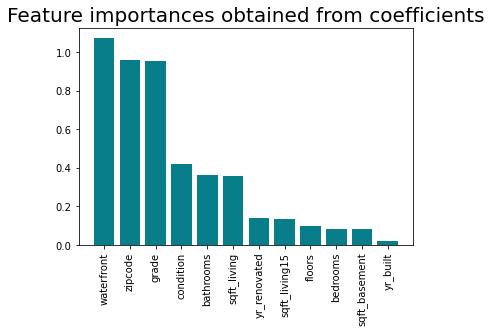

In [298]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

<AxesSubplot:xlabel='Attribute', ylabel='Importance'>

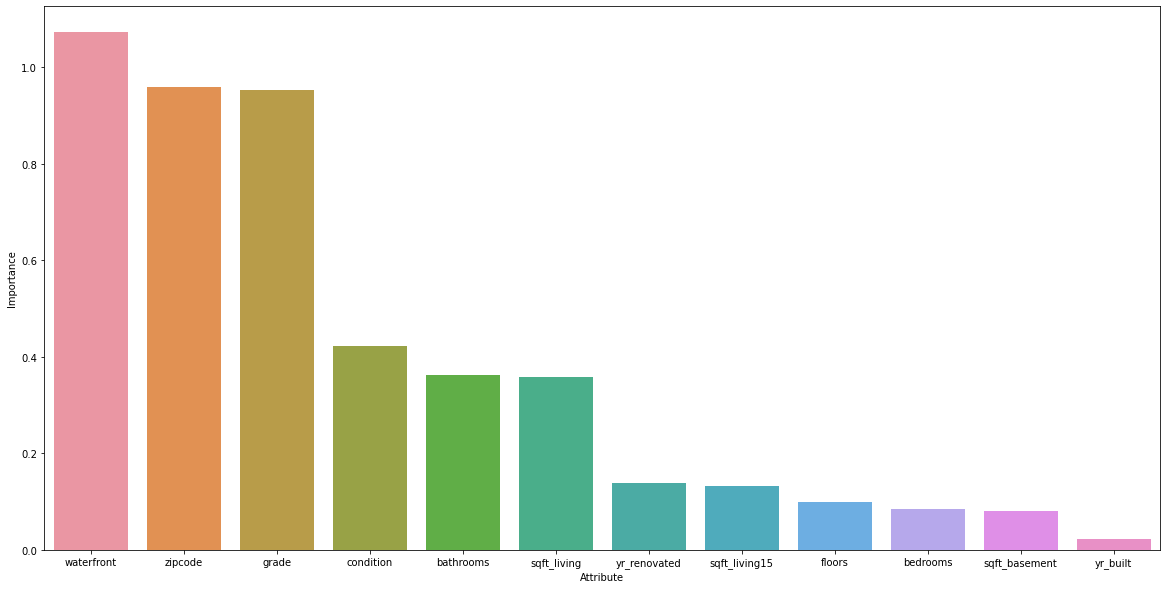

In [299]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=features_importances['Attribute'], y=features_importances['Importance'])

In [300]:
R2_train=r2_score(y_train,y_pred_train)
R2_test=r2_score(y_test,y_pred_test)
print(R2_train)
print(R2_test)

0.8655517758541094
0.864657477533294
